In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [108]:
df1 = pd.read_csv('archive/lap_times.csv')
df2 = pd.read_csv('archive/races.csv')

In [109]:
#Eldobjuk a position és az ido oszlopot, és millisecond-al dolgozunk
df1 = df1.drop('time', axis=1)
df1 = df1.drop('position', axis=1)
#Eldobjuk a 2010 előtti versenyeket, mivel 2010be tiltották meg a tankolást,
#és az üzemanyag súlya nagyban befolyásolja a köridőt, és így körről körre gyorsabb is lesz az autó, "tanulhatóbb"
df2 = df2[df2['year'] > 2009]
#eldobunk további felesleges oszlopokat
df2 = df2.drop(['round','round','date','time','url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time', 'sprint_date', 'sprint_time'], axis=1)

In [110]:
#Az inner-el csak azokat merge-eljük amiknek mind2 táblában van raceId
merged_df = pd.merge(df1, df2, on='raceId', how='inner')

In [111]:
#Leszűkítjük a keresést Hamiltonra, hogy egyszerűbb legyen (már sok driver nincs is a formula 1ben)
Ham = merged_df[(merged_df['driverId'] == 1)]

In [112]:
median = Ham['milliseconds'].median()
print(median)
#Ham = Ham[Ham['milliseconds'] <= median]
Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])

#Kiválasztjuk Monza-t
Ham = Ham[(Ham['circuitId'] == 14)]

92793.0


C:\Users\prokk\AppData\Local\Temp\ipykernel_12124\1193100888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])


In [113]:
#A név oszlopot eltávolítjuk, mert nem szükséges a modellezéshez
Ham = Ham.drop(['name'], axis=1)

#Az adatokat évekre és körökre rendezzük
#Ham = Ham.sort_values(['year', 'lap'])
Ham = Ham.sort_values(['lap'])
#Ham = Ham.sort_values(['lap','year'])

In [114]:
print(Ham)

        raceId  driverId  lap  milliseconds  year  circuitId
15554      853         1    1       89793.0  2011         14
285557    1089         1    1       89793.0  2022         14
86051      912         1    1       89793.0  2014         14
63118      892         1    1       89793.0  2013         14
103424     938         1    1       89689.0  2015         14
...        ...       ...  ...           ...   ...        ...
86103      912         1   53       89052.0  2014         14
63170      892         1   53       87940.0  2013         14
39624      872         1   53       89039.0  2012         14
103476     938         1   53       87482.0  2015         14
285609    1089         1   53       89793.0  2022         14

[608 rows x 6 columns]


In [115]:
laps = np.array(Ham['lap'])
milliseconds = np.array(Ham['milliseconds'])
print(laps)
print(milliseconds)

[ 1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12
 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18
 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22
 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 27
 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28

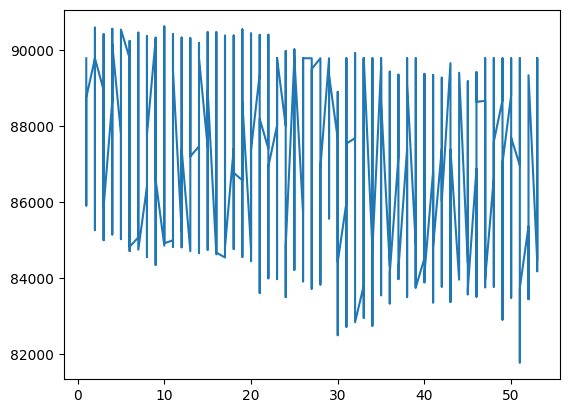

In [116]:
plt.Figure(figsize=(10,6))
plt.plot(laps,milliseconds)

In [117]:
def lookback1t1(milliseconds,look):
    X = []
    Y = []
    for i in range(0,len(milliseconds)-look):
        X.append(milliseconds[i:i+look])
        Y.append(milliseconds[i+look])
    return np.array(X),np.array(Y)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 256)               264192    
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 3s 48ms/step - loss: 7631523840.0000 - mae: 87333.3906 - val_loss: 7488892416.0000 - val_mae: 86513.6562
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 7631523840.0000 - mae: 87333.3828 - val_loss: 7488892416.0000 - val_mae: 86513.6562
Epo

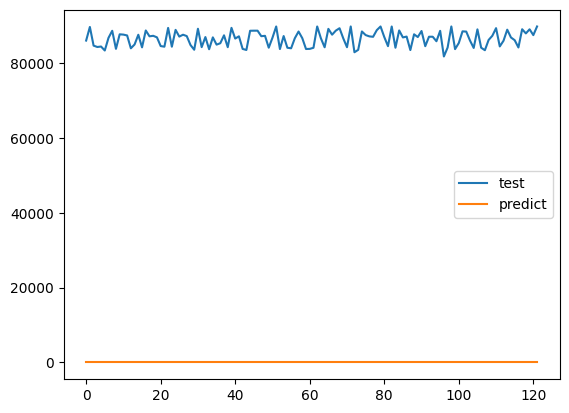

In [119]:
x,y = lookback1t1(milliseconds,1)
X_train = x[0:int(len(x)*0.8)]
X_test = x[int(len(x)*0.8):len(x)]
y_train = y[0:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):len(y)]
inputs1 = tf.keras.layers.Input(shape=(1, 1))
x = tf.keras.layers.LSTM(256)(inputs1)
out = tf.keras.layers.Dense(1,activation="linear")(x)
model = Model(inputs=inputs1, outputs=out)
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 
model.fit(X_train.tolist(),y_train.tolist(),epochs=50,validation_data=(X_test.tolist(),y_test.tolist()))
prediction = model.predict(X_test)
plt.figure()
plt.plot(y_test,label='test')
plt.plot(prediction,label='predict')
plt.legend()
plt.show()

In [105]:
def lookback(milliseconds,look):
    X = []
    Y = []
    for i in range(0,len(milliseconds)-look):
        X.append(milliseconds[i:i+look])
        Y.append(milliseconds[i+look])
    return np.array(X).reshape(len(X),look,1),np.array(Y)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 512)               1052672   
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 94ms/step - loss: 7594790912.0000 - mae: 87122.6328 - val_loss: 7619269632.0000 - val_mae: 87262.1406
Epoch 2/100
16/16 [==============================] - 1s 54ms/step - loss: 7594495488.0000 - mae: 87120.9297 - val_loss: 7618978304.0000 - val_mae: 87260.46

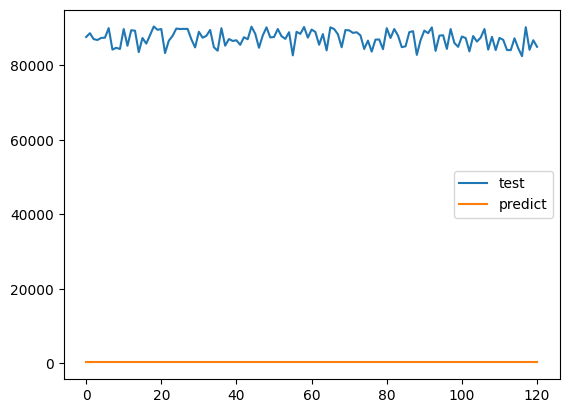

In [107]:
x,y = lookback(milliseconds,5)

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
inputs1 = tf.keras.layers.Input(shape=(5,1))
x = tf.keras.layers.LSTM(512)(inputs1)
out = tf.keras.layers.Dense(1,activation="linear")(x)
model = Model(inputs=inputs1, outputs=out)
model.summary()
model.compile(loss='mse', optimizer='adam',metrics=['mae'])
model.fit(X_train.tolist(),y_train.tolist(),epochs=100,validation_data=(X_test.tolist(),y_test.tolist()))
prediction = model.predict(X_test)
plt.figure()
plt.plot(y_test,label='test')
plt.plot(prediction,label='predict')
plt.legend()
plt.show()